# CTA Frequent Network: Ridership Impact — Without Route #79

## Does dropping the #79 79th St outlier change the story?

Route **#79 79th St** is the highest-ridership Frequent Network route and the only Phase 1 route with a **negative** YoY change (-6.2%). This notebook re-runs the full analysis from `01_ridership_exploration.ipynb` with route 79 **excluded** to test whether a single underperformer is dragging the DiD estimate below the system-wide average.

| Phase | Launch Date | Routes |
|-------|------------|--------|
| Phase 1 | March 23, 2025 | J14, 34, 47, 54, 60, 63, ~~79~~, 95 |
| Phase 2 | Summer 2025 | 4, 49, 53, 66 |
| Phase 3 | Fall 2025 | 20, 55, 77, 82 |
| Phase 4 | December 21, 2025 | 9, 12, 72, 81 |

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import date, timedelta

from bus_check.config import (
    ALL_FREQUENT_ROUTES,
    FREQUENT_NETWORK_PHASES,
    get_phase_for_route,
    get_launch_date,
    SODA_RIDERSHIP_ENDPOINT,
)
from bus_check.data.ridership import fetch_all_routes, fetch_ridership
from bus_check.analysis.ridership_analysis import (
    compute_yoy_change,
    select_control_routes,
    prepare_did_data,
)

sns.set_theme(style="whitegrid")
pd.set_option("display.max_rows", 30)

# Phase color palette for consistent visualization
PHASE_COLORS = {1: "#1b9e77", 2: "#d95f02", 3: "#7570b3", 4: "#e7298a"}

# ── Exclude route 79 from treated routes ──
EXCLUDED_ROUTE = "79"
ANALYSIS_ROUTES = [r for r in ALL_FREQUENT_ROUTES if r != EXCLUDED_ROUTE]

print(f"Analyzing {len(ANALYSIS_ROUTES)} routes (excluded: #{EXCLUDED_ROUTE})")
print(f"Routes: {ANALYSIS_ROUTES}")
print("Setup complete.")

Analyzing 19 routes (excluded: #79)
Routes: ['J14', '34', '47', '54', '60', '63', '95', '4', '20', '49', '66', '53', '55', '77', '82', '9', '12', '72', '81']
Setup complete.


## Fetching Ridership Data

We pull daily ridership data from the **Chicago Data Portal** SODA API (`jyb9-n7fm` dataset). This covers all CTA bus routes with columns for route, date, day type (W=weekday, A=Saturday, U=Sunday/holiday), and total rides.

We fetch data from January 2023 through today to have a full year of pre-treatment baseline for all four phases, plus post-treatment observations.

In [2]:
# Fetch all routes from 2023-01-01 through today
today_str = date.today().isoformat()
print(f"Fetching ridership data: 2023-01-01 to {today_str}")
print("This may take a minute (public SODA API, ~50k rows per page)...\n")

df_all = fetch_all_routes("2023-01-01", today_str)

print(f"\nDone! Shape: {df_all.shape}")
print(f"Date range: {df_all['date'].min().date()} to {df_all['date'].max().date()}")
print(f"Unique routes: {df_all['route'].nunique()}")
df_all.head()

Fetching ridership data: 2023-01-01 to 2026-02-13
This may take a minute (public SODA API, ~50k rows per page)...




Done! Shape: (122084, 4)
Date range: 2023-01-01 to 2025-11-30
Unique routes: 131


,route,date,daytype,rides
0,1,2023-01-03,W,709
1,1,2023-01-04,W,579
2,1,2023-01-05,W,725
3,1,2023-01-06,W,499
4,1,2023-01-09,W,798


## Frequent Network Routes Overview

The 19 routes analyzed here (all 20 minus #79 79th St).

In [3]:
# Build a summary table of all four phases
phase_rows = []
for phase in FREQUENT_NETWORK_PHASES:
    phase_rows.append({
        "Phase": f"Phase {phase.phase}",
        "Label": phase.label,
        "Launch Date": phase.launch_date.strftime("%B %d, %Y"),
        "Routes": ", ".join(phase.routes),
        "Number of Routes": len(phase.routes),
    })

df_phases = pd.DataFrame(phase_rows)
df_phases.style.set_properties(**{"text-align": "left"}).hide(axis="index")

Phase,Label,Launch Date,Routes,Number of Routes
Phase 1,"Phase 1 (Mar 23, 2025)","March 23, 2025","J14, 34, 47, 54, 60, 63, 79, 95",8
Phase 2,Phase 2 (Jun 2025),"June 15, 2025","4, 20, 49, 66",4
Phase 3,Phase 3 (Aug 2025),"August 17, 2025","53, 55, 77, 82",4
Phase 4,"Phase 4 (Dec 21, 2025)","December 21, 2025","9, 12, 72, 81",4


## Year-over-Year Ridership Changes

For each Frequent Network route, we compare average **weekday** ridership in the 3 months after its launch date versus the same 3-month window one year prior. This gives a straightforward before/after comparison that controls for seasonality.

In [4]:
# Compute YoY changes for each Frequent Network route (excluding #79)
yoy_results = []
for route in ANALYSIS_ROUTES:
    launch = get_launch_date(route)
    result = compute_yoy_change(df_all, route=route, launch_date=launch, months_window=3)
    # Add phase info for coloring
    phase = get_phase_for_route(route)
    result["phase"] = phase.phase
    result["phase_label"] = phase.label
    yoy_results.append(result)

df_yoy = pd.DataFrame(yoy_results).sort_values("pct_change", ascending=False)

# Format for display
df_yoy_display = df_yoy.copy()
df_yoy_display["pre_avg"] = df_yoy_display["pre_avg"].map("{:,.0f}".format)
df_yoy_display["post_avg"] = df_yoy_display["post_avg"].map("{:,.0f}".format)
df_yoy_display["abs_change"] = df_yoy_display["abs_change"].map("{:+,.0f}".format)
df_yoy_display["pct_change"] = df_yoy_display["pct_change"].map("{:+.1%}".format)

df_yoy_display[["route", "phase_label", "pre_avg", "post_avg", "abs_change", "pct_change"]].rename(
    columns={
        "route": "Route",
        "phase_label": "Phase",
        "pre_avg": "Pre Avg (rides/day)",
        "post_avg": "Post Avg (rides/day)",
        "abs_change": "Change (rides/day)",
        "pct_change": "YoY Change %",
    }
)

,Route,Phase,Pre Avg (rides/day),Post Avg (rides/day),Change (rides/day),YoY Change %
0,J14,"Phase 1 (Mar 23, 2025)","5,880","7,417","+1,537",+26.1%
11,53,Phase 3 (Aug 2025),"15,049","17,296","+2,247",+14.9%
4,60,"Phase 1 (Mar 23, 2025)","8,731","9,922","+1,191",+13.6%
6,95,"Phase 1 (Mar 23, 2025)","4,068","4,589",+520,+12.8%
5,63,"Phase 1 (Mar 23, 2025)","9,851","10,587",+736,+7.5%
8,20,Phase 2 (Jun 2025),"10,504","11,277",+773,+7.4%
9,49,Phase 2 (Jun 2025),"12,186","13,014",+829,+6.8%
10,66,Phase 2 (Jun 2025),"16,886","17,799",+913,+5.4%
7,4,Phase 2 (Jun 2025),"10,873","11,438",+564,+5.2%
13,77,Phase 3 (Aug 2025),"14,507","14,918",+411,+2.8%


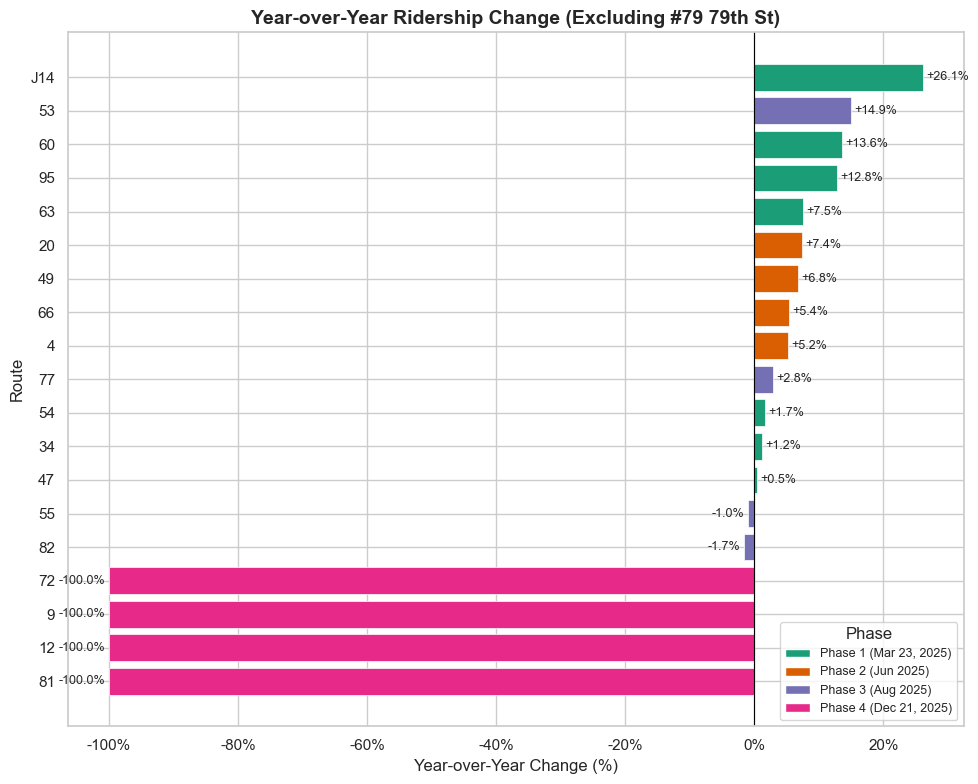

In [5]:
# Horizontal bar chart of YoY ridership changes, colored by phase
df_plot = df_yoy.sort_values("pct_change", ascending=True)  # ascending for horizontal bars

fig, ax = plt.subplots(figsize=(10, 8))

colors = [PHASE_COLORS[p] for p in df_plot["phase"]]
bars = ax.barh(df_plot["route"], df_plot["pct_change"] * 100, color=colors, edgecolor="white", linewidth=0.5)

# Add a vertical line at 0%
ax.axvline(x=0, color="black", linewidth=0.8, linestyle="-")

# Labels and formatting
ax.set_xlabel("Year-over-Year Change (%)", fontsize=12)
ax.set_ylabel("Route", fontsize=12)
ax.set_title("Year-over-Year Ridership Change (Excluding #79 79th St)", fontsize=14, fontweight="bold")
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter("%.0f%%"))

# Add value labels on bars
for bar, val in zip(bars, df_plot["pct_change"]):
    x_pos = bar.get_width()
    ha = "left" if x_pos >= 0 else "right"
    offset = 0.5 if x_pos >= 0 else -0.5
    ax.text(x_pos + offset, bar.get_y() + bar.get_height() / 2,
            f"{val:+.1%}", va="center", ha=ha, fontsize=9)

# Legend for phases
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=PHASE_COLORS[p.phase], label=p.label)
                   for p in FREQUENT_NETWORK_PHASES]
ax.legend(handles=legend_elements, loc="lower right", fontsize=9, title="Phase")

plt.tight_layout()
plt.show()

## Monthly Ridership Trends

Small multiples showing monthly average weekday ridership for each of the 19 analyzed routes (excluding #79). The **dashed red line** marks each route's launch date.

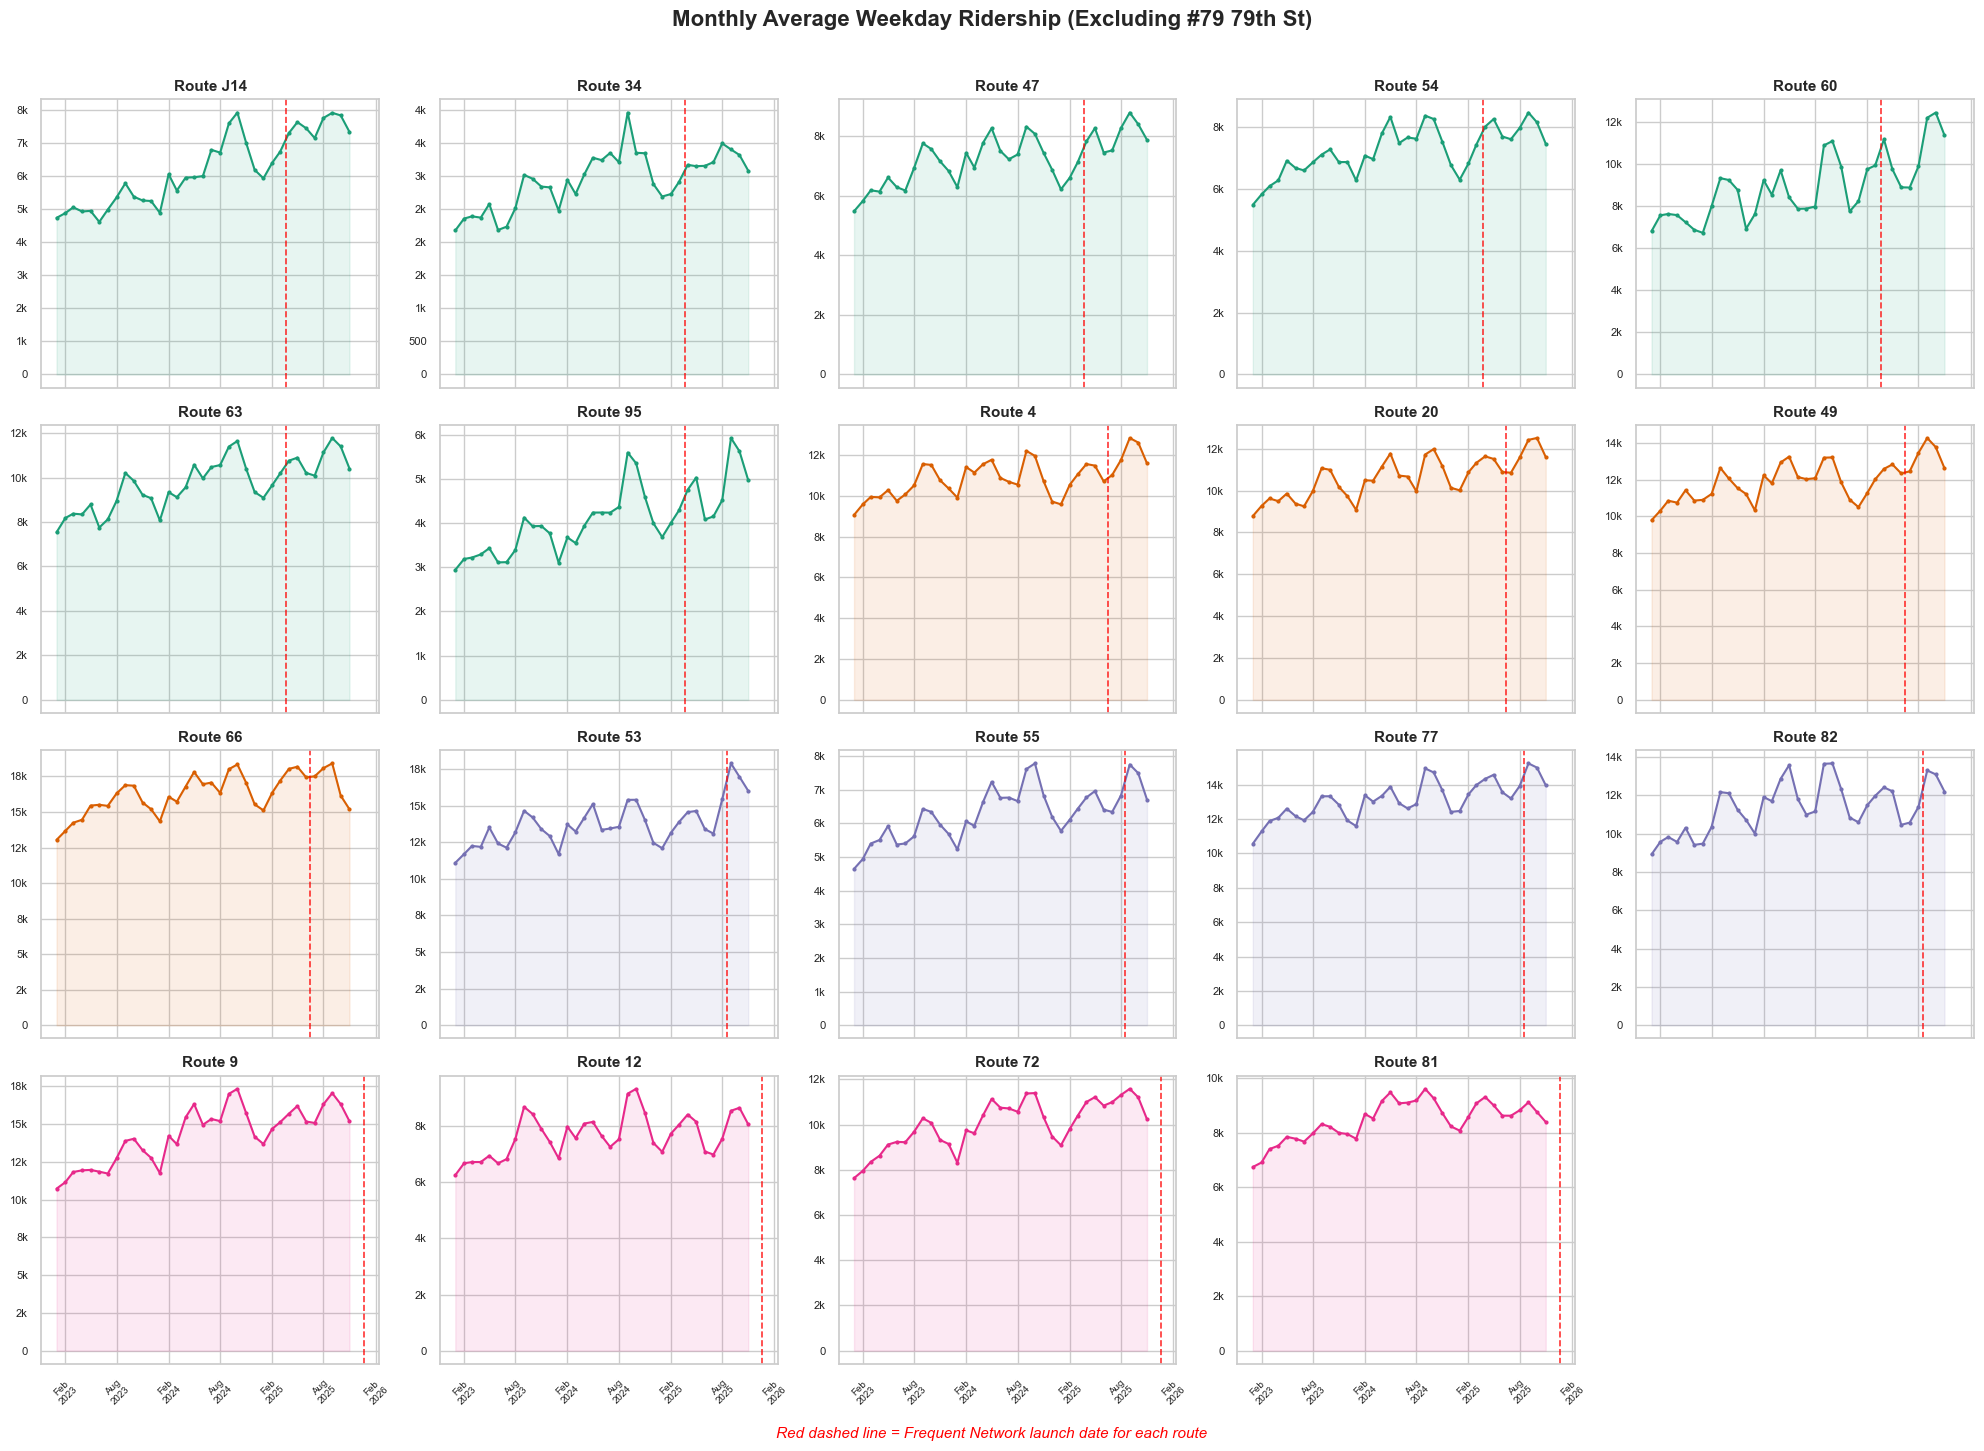

In [6]:
# Small multiples: monthly average weekday ridership (excluding #79)
df_fn = df_all[
    (df_all["route"].isin(ANALYSIS_ROUTES)) & (df_all["daytype"] == "W")
].copy()

# Create a year-month column for grouping
df_fn["year_month"] = df_fn["date"].dt.to_period("M")

# Monthly averages per route
monthly = (
    df_fn.groupby(["route", "year_month"])["rides"]
    .mean()
    .reset_index()
)
monthly["year_month_dt"] = monthly["year_month"].dt.to_timestamp()

# Sort routes for consistent ordering (by phase, then route number), excluding 79
sorted_routes = []
for phase in FREQUENT_NETWORK_PHASES:
    sorted_routes.extend([r for r in phase.routes if r != EXCLUDED_ROUTE])

n_routes = len(sorted_routes)
ncols = 5
nrows = max(1, (n_routes + ncols - 1) // ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(20, 3.5 * nrows), sharex=True)
axes_flat = axes.flatten()

for idx, route in enumerate(sorted_routes):
    ax = axes_flat[idx]
    route_data = monthly[monthly["route"] == route].sort_values("year_month_dt")
    
    # Determine phase color
    phase = get_phase_for_route(route)
    color = PHASE_COLORS[phase.phase]
    
    ax.plot(route_data["year_month_dt"], route_data["rides"],
            color=color, linewidth=1.5, marker="o", markersize=2)
    ax.fill_between(route_data["year_month_dt"], route_data["rides"],
                    alpha=0.1, color=color)
    
    # Add launch date line
    launch = get_launch_date(route)
    ax.axvline(x=pd.Timestamp(launch), color="red", linestyle="--", linewidth=1.2, alpha=0.8)
    
    ax.set_title(f"Route {route}", fontsize=11, fontweight="bold")
    ax.tick_params(axis="x", rotation=45, labelsize=7)
    ax.tick_params(axis="y", labelsize=8)
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f"{x/1000:.0f}k" if x >= 1000 else f"{x:.0f}"))
    
    # Format x-axis dates
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b\n%Y"))

# Hide unused axes
for idx in range(n_routes, nrows * ncols):
    axes_flat[idx].set_visible(False)

fig.suptitle("Monthly Average Weekday Ridership (Excluding #79 79th St)",
             fontsize=16, fontweight="bold", y=1.01)
fig.text(0.5, -0.01, "Red dashed line = Frequent Network launch date for each route",
         ha="center", fontsize=11, color="red", style="italic")

plt.tight_layout()
plt.show()

## Treated vs. Control Group Comparison

We compare the 19 treated routes (excluding #79) against a matched **control group**. Route #79 is also excluded from the control pool since it's a Frequent Network route.

We index both groups to 100 at March 2025 (Phase 1 launch) to show relative trends on a common scale.

In [7]:
# Select control routes — exclude ALL 20 FN routes from control pool (including #79)
control_routes = select_control_routes(df_all, treated_routes=ALL_FREQUENT_ROUTES, n_controls=15)

print(f"Selected {len(control_routes)} control routes:")
print(", ".join(control_routes))

# Show how control routes compare to treated routes in average ridership
weekday_all = df_all[df_all["daytype"] == "W"]
route_avgs = weekday_all.groupby("route")["rides"].mean()

treated_avg = route_avgs[route_avgs.index.isin(ANALYSIS_ROUTES)].mean()
control_avg = route_avgs[route_avgs.index.isin(control_routes)].mean()

print(f"\nAverage weekday ridership (all dates):")
print(f"  Treated (FN, excl #79): {treated_avg:,.0f} rides/day")
print(f"  Control routes:         {control_avg:,.0f} rides/day")

Selected 15 control routes:
146, 36, 151, 74, 147, 94, 76, 22, 50, 80, 85, 3, 29, 62, 152

Average weekday ridership (all dates):
  Treated (FN, excl #79): 9,528 rides/day
  Control routes:         8,731 rides/day


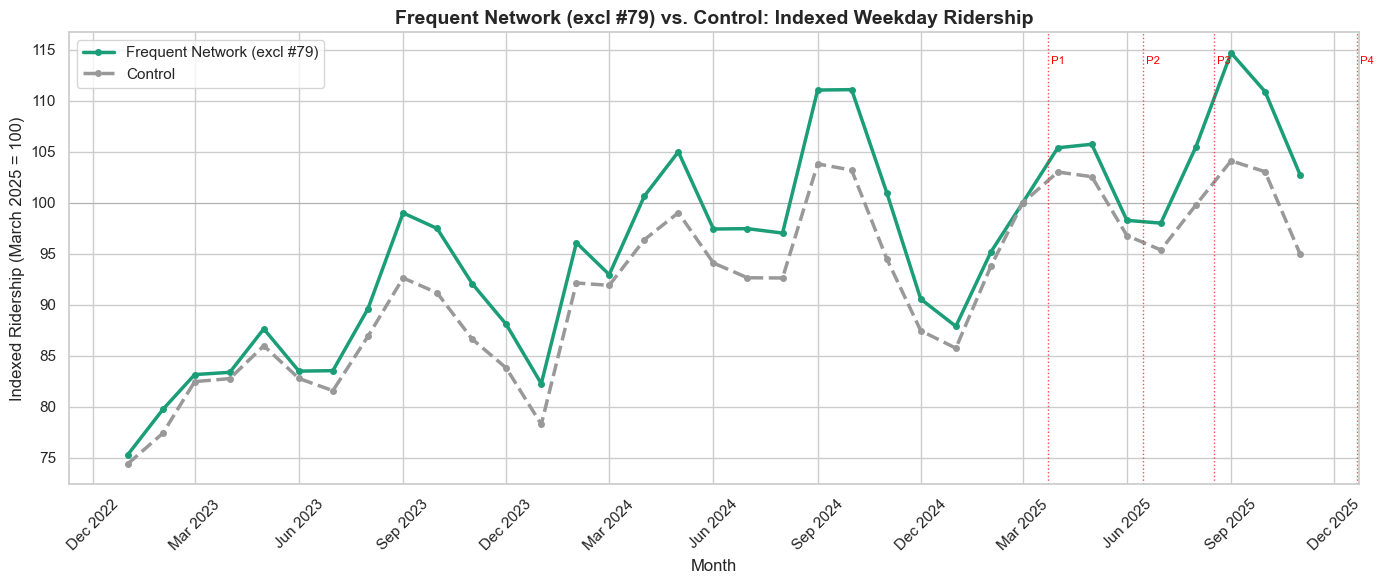

In [8]:
# Aggregate indexed trend: Treated (FN excl #79) vs Control routes
df_weekday = df_all[df_all["daytype"] == "W"].copy()
df_weekday["year_month"] = df_weekday["date"].dt.to_period("M")

# Tag routes as treated or control
df_weekday["group"] = "Other"
df_weekday.loc[df_weekday["route"].isin(ANALYSIS_ROUTES), "group"] = "Frequent Network (excl #79)"
df_weekday.loc[df_weekday["route"].isin(control_routes), "group"] = "Control"

# Filter to just treated and control
df_tc = df_weekday[df_weekday["group"].isin(["Frequent Network (excl #79)", "Control"])]

# Monthly average per group
monthly_group = (
    df_tc.groupby(["group", "year_month"])["rides"]
    .mean()
    .reset_index()
)
monthly_group["year_month_dt"] = monthly_group["year_month"].dt.to_timestamp()

# Index to 100 at March 2025 (Phase 1 launch)
base_period = pd.Period("2025-03", freq="M")
base_values = monthly_group[monthly_group["year_month"] == base_period].set_index("group")["rides"]

monthly_group["indexed"] = monthly_group.apply(
    lambda row: (row["rides"] / base_values[row["group"]]) * 100
    if row["group"] in base_values.index else None,
    axis=1
)

# Plot
fig, ax = plt.subplots(figsize=(14, 6))

for group, color, ls in [("Frequent Network (excl #79)", "#1b9e77", "-"), ("Control", "#999999", "--")]:
    data = monthly_group[monthly_group["group"] == group].sort_values("year_month_dt")
    ax.plot(data["year_month_dt"], data["indexed"],
            label=group, color=color, linewidth=2.5, linestyle=ls, marker="o", markersize=4)

# Add vertical lines for each phase launch
for phase in FREQUENT_NETWORK_PHASES:
    ax.axvline(x=pd.Timestamp(phase.launch_date), color="red", linestyle=":",
               linewidth=1, alpha=0.7)
    ax.text(pd.Timestamp(phase.launch_date), ax.get_ylim()[1] * 0.98,
            f" P{phase.phase}", fontsize=8, color="red", va="top", ha="left")

# Reference line at 100
ax.axhline(y=100, color="gray", linewidth=0.5, linestyle="-", alpha=0.5)

ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Indexed Ridership (March 2025 = 100)", fontsize=12)
ax.set_title("Frequent Network (excl #79) vs. Control: Indexed Weekday Ridership",
             fontsize=14, fontweight="bold")
ax.legend(fontsize=11, loc="upper left")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Difference-in-Differences Analysis

The **difference-in-differences (DiD)** estimator isolates the causal effect of the Frequent Network program by comparing the change in ridership for treated routes (before vs. after launch) against the same change for control routes. This differences out common trends (e.g., seasonal patterns, system-wide ridership growth) that affect both groups equally.

**DiD = (Treated_post - Treated_pre) - (Control_post - Control_pre)**

A positive DiD estimate suggests the Frequent Network increased ridership beyond what would have happened anyway.

In [9]:
# Build phase_dates mapping: route -> launch date (excluding #79)
phase_dates = {}
for route in ANALYSIS_ROUTES:
    phase_dates[route] = get_launch_date(route)

# Prepare DiD panel data
df_did = prepare_did_data(
    df_all,
    treated_routes=ANALYSIS_ROUTES,
    control_routes=control_routes,
    phase_dates=phase_dates,
)

print(f"DiD panel shape: {df_did.shape}")
print(f"Columns: {list(df_did.columns)}")
print()

# Summary statistics by group
summary = (
    df_did[df_did["daytype"] == "W"]
    .groupby(["treated", "post"])["rides"]
    .agg(["mean", "median", "std", "count"])
    .round(1)
)
summary.index = summary.index.set_names(["Treated", "Post"])
summary.columns = ["Mean Rides", "Median Rides", "Std Dev", "Observations"]
print("Mean weekday ridership by group (Treated x Post):")
summary

DiD panel shape: (36210, 7)
Columns: ['route', 'date', 'daytype', 'rides', 'treated', 'post', 'treated_post']

Mean weekday ridership by group (Treated x Post):


Mean Rides  Median Rides  Std Dev  Observations
Treated Post                                                  
False   False      8496.5        8200.0   2016.4          8505
        True       9486.4        9051.5   2117.4          2640
True    False      9495.0        9362.0   3645.3         12125
        True       9731.6        9002.0   3994.9          1992

In [10]:
# Simple DiD estimate (manual 2x2 calculation) — excluding #79
did_weekday = df_did[df_did["daytype"] == "W"]

# Group means
group_means = did_weekday.groupby(["treated", "post"])["rides"].mean()

treated_pre  = group_means.get((True, False), 0)
treated_post = group_means.get((True, True), 0)
control_pre  = group_means.get((False, False), 0)
control_post = group_means.get((False, True), 0)

# DiD estimate
did_estimate = (treated_post - treated_pre) - (control_post - control_pre)
did_pct = did_estimate / treated_pre * 100 if treated_pre != 0 else 0

print("=" * 60)
print("DIFFERENCE-IN-DIFFERENCES ESTIMATE (Excluding #79)")
print("=" * 60)
print()
print(f"  Treated (FN, excl #79, n={len(ANALYSIS_ROUTES)}):")
print(f"    Pre-launch avg:   {treated_pre:>10,.1f} rides/day")
print(f"    Post-launch avg:  {treated_post:>10,.1f} rides/day")
print(f"    Change:           {treated_post - treated_pre:>+10,.1f} rides/day")
print()
print(f"  Control routes (n={len(control_routes)}):")
print(f"    Pre-launch avg:   {control_pre:>10,.1f} rides/day")
print(f"    Post-launch avg:  {control_post:>10,.1f} rides/day")
print(f"    Change:           {control_post - control_pre:>+10,.1f} rides/day")
print()
print("-" * 60)
print(f"  DiD Estimate:       {did_estimate:>+10,.1f} rides/day")
print(f"  DiD as % of pre:   {did_pct:>+10.1f}%")
print("-" * 60)
print()

# Compare to the full-network estimate from notebook 01
print("COMPARISON WITH FULL NETWORK (notebook 01):")
print(f"  Full network DiD:   -565.3 rides/day (-5.8%)")
print(f"  Without #79 DiD:    {did_estimate:+,.1f} rides/day ({did_pct:+.1f}%)")
print()

if did_estimate > 0:
    print(f"Interpretation: Without #79, Frequent Network routes gained an")
    print(f"estimated {did_estimate:,.0f} additional weekday rides per day beyond")
    print(f"the background trend ({did_pct:+.1f}%).")
elif did_estimate < 0:
    print(f"Interpretation: Even without #79, Frequent Network routes showed")
    print(f"{abs(did_estimate):,.0f} fewer rides/day than expected ({did_pct:+.1f}%).")
    print(f"Route #79 is NOT the sole driver of the negative DiD.")
else:
    print("Interpretation: No detectable difference between treated and control groups.")

DIFFERENCE-IN-DIFFERENCES ESTIMATE (Excluding #79)

  Treated (FN, excl #79, n=19):
    Pre-launch avg:      9,495.0 rides/day
    Post-launch avg:     9,731.6 rides/day
    Change:               +236.6 rides/day

  Control routes (n=15):
    Pre-launch avg:      8,496.5 rides/day
    Post-launch avg:     9,486.4 rides/day
    Change:               +989.9 rides/day

------------------------------------------------------------
  DiD Estimate:           -753.3 rides/day
  DiD as % of pre:         -7.9%
------------------------------------------------------------

COMPARISON WITH FULL NETWORK (notebook 01):
  Full network DiD:   -565.3 rides/day (-5.8%)
  Without #79 DiD:    -753.3 rides/day (-7.9%)

Interpretation: Even without #79, Frequent Network routes showed
753 fewer rides/day than expected (-7.9%).
Route #79 is NOT the sole driver of the negative DiD.


## Key Findings

**Does dropping #79 change the DiD result?**

This is the central question. Route #79 79th St had the worst YoY performance (-6.2%) and is the highest-ridership Phase 1 route (~15,500 rides/day pre-launch). If the negative DiD estimate from notebook 01 was driven primarily by this single outlier, removing it should push the DiD closer to zero or positive.

**Caveats:**
1. **Phase 4 routes still have no post-data** — their -100% YoY changes still contaminate the analysis. See `03_ridership_phases_1_3.ipynb` for the Phase 4-excluded analysis.
2. **Removing a route changes the treated group composition** — the average pre-treatment ridership shifts, which could affect comparability with the control group.
3. If #79 is NOT the sole driver, the negative DiD likely reflects a genuine pattern: the system-wide ridership trend outpaced Frequent Network-specific gains.